# PINN for Harmonic Oscillator

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Brief Overview of Damped Harmonic Oscillator

A harmonic oscillator is a physical system that experiences a restoring force proportional to its displacement from equilibrium. In real life, oscillators experience a resistive force such as friction, that opposes its motion, causing it to lose energy over time. These are known as *damped harmonic oscillators*.

In a damped harmonic oscillator, the balance of forces can be described by the following differential equation:

$$
m \frac{d^2y}{dt^2} + c \frac{dy}{dt} + ky = 0
$$


- $ m \frac{d^2y}{dt^2} $ is the *inertial force*, *mass* multiplied by *acceleration*. This term represents the inertial resistance of the object to changes in motion.

- $ c \frac{dy}{dt} $ is the *damping force*, the product of the *damping coefficient*,  $c$ and the *velocity*. This force opposes the motion and is responsible for the gradual reduction in the amplitude of oscillation over time.

- $ ky $: This is the *restoring force*, where $k$ is the *spring constant*, and $y$ is the *displacement* from the equilibrium position. This force tries to return the system to its equilibrium position and is derived from *Hooke's Law*.

In the absence of any external driving force, the net force acting on the object must be zero because the system is in dynamic equilibrium at every instant, In other words, the motion of the system adheres to *Newton's Second Law of Motion*.

In this notebook, we will explore an *underdamped harmonic oscillator*. This type of system exhibits oscillatory behavior with a gradually decreasing amplitude due to insufficient damping. This occurs when:

$$
\delta < \omega_0 ~\text{where}~ \delta = \frac{c}{2m}, ~ \omega_0 = \sqrt{\frac{k}{m}}
$$

For our oscillator, we will use the following boundary conditions:

$$
y(t=0) = 1 ~,~ \frac{dy}{dt} (t = 0 ) = 0
$$

The displacement of such system as a function of time can be expressed as:

$$
y(t) = 2 A e^{-\delta t} \cos(\omega t + \phi)
$$

where:
- $ A $ is the initial amplitude of the oscillation.
- $ \delta $ is the rate at which the amplitude decays due to damping.
- $ \omega $ is the damped angular frequency, $\omega = \sqrt{\omega_0^2 - \delta^2}$.
- $ \phi $ is the phase angle at $t = 0$, $\phi = \arctan\left(-\frac{\delta}{\omega}\right)$.

In [2]:
def displacement(t:np.ndarray, delta:float, omega_0:float,) -> np.ndarray:
    omega = np.sqrt(omega_0**2 - delta**2)

    phi = np.arctan(-delta / omega)
    A = 1 / (2 * np.cos(phi))
    
    return 2 * A * np.exp(-delta * t) * np.cos(omega * t + phi)

## Defining the Model Architecture

Below, we define the architecture of a model.

In [3]:
class Model(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, hidden_channels:int, num_hidden_layers:int=2) -> None:
        super().__init__()

        self.input_layer = nn.Linear(in_channels, hidden_channels)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels)for _ in range(num_hidden_layers)
        ])

        self.output_layer = nn.Linear(hidden_channels, out_channels)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.tanh(self.input_layer(x))
        
        for hidden_layer in self.hidden_layers:
            x = F.tanh(hidden_layer(x))

        x = self.output_layer(x)

        return x

## Simulating a System

Here, we are training a Physics-Informed Neural Network (PINN) to approximate the solution of the differential equation that governs the behavior of the system. The goal of the PINN is to learn the relationship between the time variable, $t$ and the solution $y(t)$.

Mathematically, the neural network is designed to approximate the true solution:
$$
NN(t; \theta) \approx y(t)
$$

The total loss function for simulating our underdamped harmonic oscillator is expressed as:

$$
loss_{total} = loss_{boundary1} + \lambda_1 \times loss_{boundary2} + \lambda_2 \times loss_{physics}
$$

This loss function combines both the boundary conditions and the underlying physical laws governing the harmonic oscillator.

- **Boundary Condition Loss 1**

    $$
    loss_{boundary1} = (NN(0; \theta) - 1)^2
    $$

    This term enforces the boundary condition $y(t=0) = 1$. The neural network $NN(t; \theta)$ predicts the solution at different time steps, and this specific loss ensures that the prediction at $t = 0$ is close to 1. Any deviation from the true boundary value is penalized, encouraging the network to satisfy the initial position condition.

- **Boundary Condition Loss 2**

    $$
    loss_{boundary2} = \left(\frac{dNN}{dt}(0; \theta) - 0\right)^2
    $$

    This term enforces the condition $\frac{dy}{dt}(t=0) = 0$, which indicates that the velocity of the oscillator at $t = 0$ should be zero. Here, the network is penalized if the predicted velocity (the derivative of $NN(t; \theta)$ with respect to time) at $t = 0$ deviates from zero.

- **Physics Loss**

    $$
    loss_{physics} = \frac{1}{N} \sum^{N}_{i} \left(m \frac{d^2y}{dt^2} + c \frac{dy}{dt} + k \times NN(t_i; \theta)\right)^2
    $$

    This term enforces the physical laws that govern the motion of a harmonic oscillator, $m \frac{d^2y}{dt^2} + c \frac{dy}{dt} + ky = 0 $. This loss is computed by evaluating how closely the neural network's predictions adhere to this differential equation at multiple time points, $t_i$. If the network's predictions violate the oscillator's physical law, this term penalizes those errors, ensuring the network learns a physically consistent solution.

- **Weighting Factors**, $\lambda_1$ and $\lambda_2$
    
    These are hyperparameters that control the relative importance of the second boundary condition loss and the physics loss respectively.

For our simulation, we assume the following parameters:

- Decay rate: $\delta = 2$
- Natural frequency: $\omega_0 = 20$
- Mass: $m = 1$

We will simulate the system over the time interval, $t \in [0, 1]$.

In [4]:
d = 2
w0 = 20
m = 1

c = d * 2 * m
k = (w0**2) * m 

# time values for the interval [0, 1]
t_physics = np.linspace(0, 1, 100)
y_physics = displacement(t_physics, d, w0)

t_physics = torch.tensor(t_physics, dtype=torch.float32).view(-1,1).requires_grad_(True)
y_physics = torch.tensor(y_physics, dtype=torch.float32).view(-1,1).requires_grad_(True)

# t = 0
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# weighting factors
lambda_1, lambda_2 = 1e-1, 1e-4

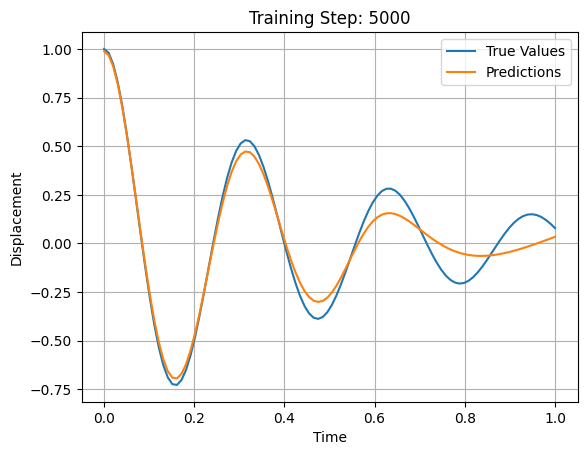

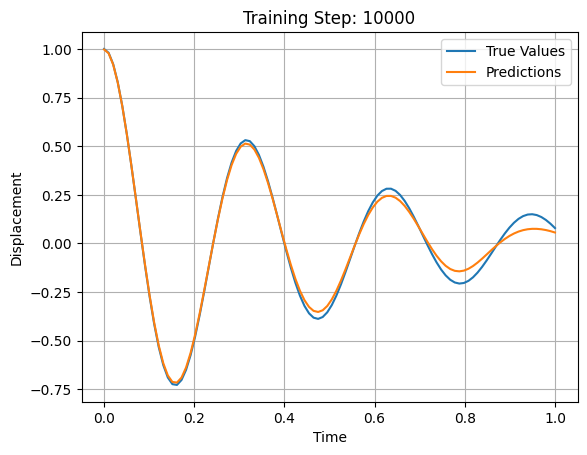

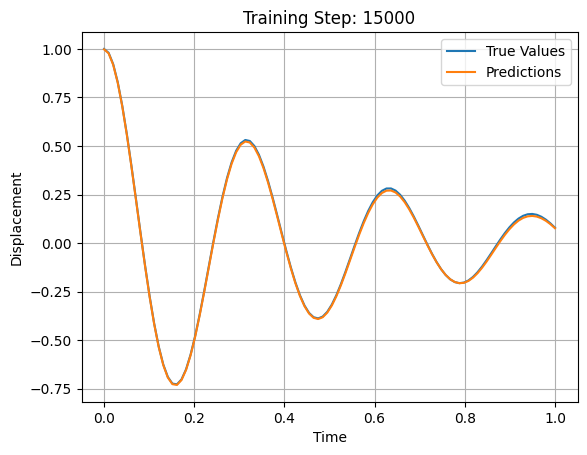

In [5]:
pinn = Model(1, 1, 32)
optimiser = optim.Adam(pinn.parameters(), lr=1e-3)

num_training_steps = 15000
for training_step in range(num_training_steps):
    optimiser.zero_grad()

    # First Boundary Loss
    y = pinn(t_boundary)
    loss1 = (torch.squeeze(y) - 1)**2

    # Second Boundary Loss
    dy_dt = torch.autograd.grad(y, t_boundary, torch.ones_like(y), create_graph=True)[0]
    loss2 = (torch.squeeze(dy_dt) - 0)**2
    
    # Physics Loss
    y = pinn(t_physics)
    dy_dt = torch.autograd.grad(y, t_physics, torch.ones_like(y), create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t_physics, torch.ones_like(dy_dt), create_graph=True)[0]
    loss3 = torch.mean((m * d2y_dt2 + c * dy_dt + k * y)**2)
    
    # Total Loss
    loss = loss1 + lambda_1 * loss2 + lambda_2 * loss3

    loss.backward()
    optimiser.step()

    if (training_step + 1) % 5000 == 0:
        plt.plot(t_physics.detach().numpy(), y_physics.detach().numpy(), label="True Values")
        plt.plot(t_physics.detach().numpy(), pinn(t_physics).detach().numpy(), label="Predictions")
        plt.xlabel("Time")
        plt.ylabel("Displacement")
        plt.title(f"Training Step: {training_step + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

## Infering a System's Parameters

For this, we are training a Physics-Informed Neural Network (PINN) to infer the underlying parameters of a physical system by leveraging both observed data and the governing physics equations. We want to estimate the damping coefficient of an underdamped harmonic oscillator, using noisy observations of the oscillator's displacement as inputs.

Again, mathematically, the neural network is designed to approximate the true solution:
$$
NN(t; \theta) \approx y(t)
$$

However we assume $c$, the damping coefficient is not known and we consider it as an *additional learnable parameter*.

The total loss function, $\mathcal{L}(\theta, c)$ is given by:

$$
loss_{total} = loss_{physics} + \lambda \times loss_{data}
$$

This equation balances the contribution of two components: Physics Loss and Data Loss.

- **Physics Loss**

    $$
    loss_{physics} = \frac{1}{N} \sum^{N}_{i} \left(m \frac{d^2y}{dt^2} + c \frac{dy}{dt} + k \times NN(t_i; \theta)\right)^2
    $$

    This represents the physics-informed component of the loss, where the differential equation governing the system is enforced.

- **Data Loss**

    $$
    loss_{data} = \frac{1}{M} \sum_{j=1}^{M} \left( N\!N(t_{j}; \theta) - y_{\mathrm{obs}}(t_{j}) \right)^2
    $$ 

    This represents the data-informed component, where the network's output is compared to the noisy observed data $y_{\mathrm{obs}}(t_j)$. It takes the mean squared error between the neural network’s output $NN(t_j; \theta)$ and the observations at various time points $t_j$.

- **Weighting Factor**, $\lambda$

    The weighting factor is a hyperparameter that controls the trade-off between the physics-informed loss and the data-informed loss.


To simulate the data for our experiment, we will first create synthetic observational data of an underdamped harmonic oscillator with a known damping coefficient of 4.  The process involves generating displacement data from the system's true dynamics and then adding noise to reflect real-world measurement errors.

In [6]:
d = 2
w0 = 20
m = 1

k = (w0**2) * m
print(f"True value of c: {d * 2 * m}")

t_obs = np.random.uniform(0, 1, 30)

true_displacement = displacement(t_obs, d, w0)

# Adding noise
noise = 0.04 * np.ones_like(true_displacement)
y_obs = true_displacement + noise

t_obs = torch.tensor(t_obs, dtype=torch.float32).view(-1,1).requires_grad_(True)
y_obs = torch.tensor(y_obs, dtype=torch.float32).view(-1,1).requires_grad_(True)

# for the physics loss
t_physics = np.linspace(0, 1, 100)
t_physics = torch.tensor(t_physics, dtype=torch.float32).view(-1,1).requires_grad_(True)

# weighting factor
lambda_1 = 1e4

True value of c: 4


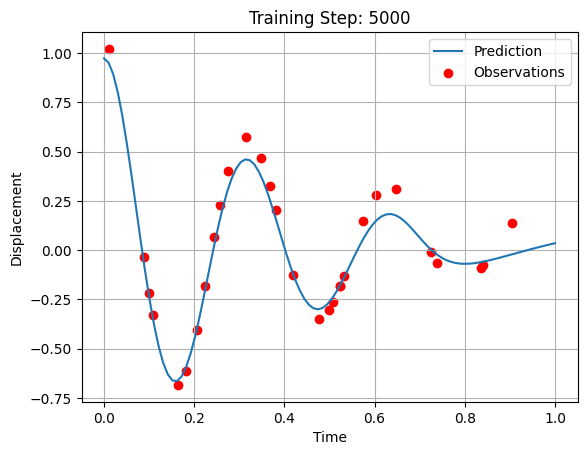

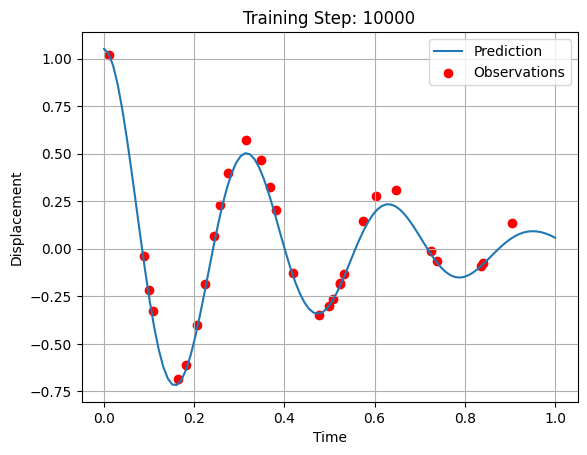

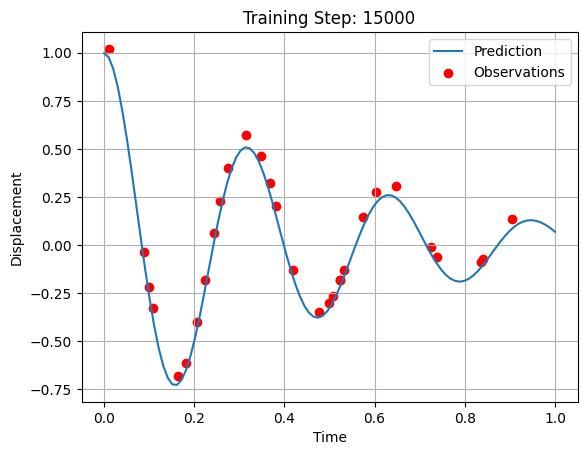

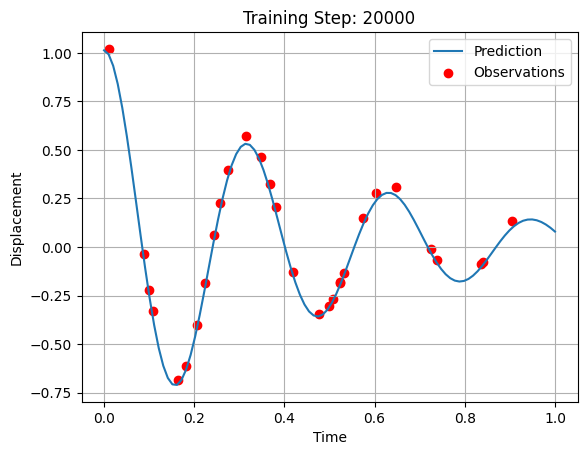

In [7]:
pinn = Model(1, 1, 32)

# c is a learnable parameter
c = torch.nn.Parameter(torch.zeros(1, requires_grad=True))

optimiser = optim.Adam(list(pinn.parameters())+[c], lr=1e-3)

# store the values of c over the training steps
c_values = []

num_training_steps = 20000
for training_step in range(num_training_steps):
    optimiser.zero_grad()

    # Physics Loss
    y = pinn(t_physics)
    dy_dt = torch.autograd.grad(y, t_physics, torch.ones_like(y), create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t_physics, torch.ones_like(dy_dt), create_graph=True)[0]
    loss_1 = torch.mean((m * d2y_dt2 + c * dy_dt + k * y)**2)

    # Data Loss
    y = pinn(t_obs)
    loss_2 = torch.mean((y - y_obs)**2)

    # Total Loss
    loss = loss_1 + lambda_1 * loss_2

    loss.backward()
    optimiser.step()

    c_values.append(c.item())

    if (training_step + 1) % 5000 == 0:
        plt.figure()
        plt.plot(t_physics.detach().numpy(), pinn(t_physics).detach().numpy(), label="Prediction")
        plt.scatter(t_obs.detach().numpy(), y_obs.detach().numpy(), label="Observations", color="red")
        plt.xlabel("Time")
        plt.ylabel("Displacement")
        plt.title(f"Training Step: {training_step + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

Let us visualize how the parameter, $c$ evolves during training and compare it to the known true value.

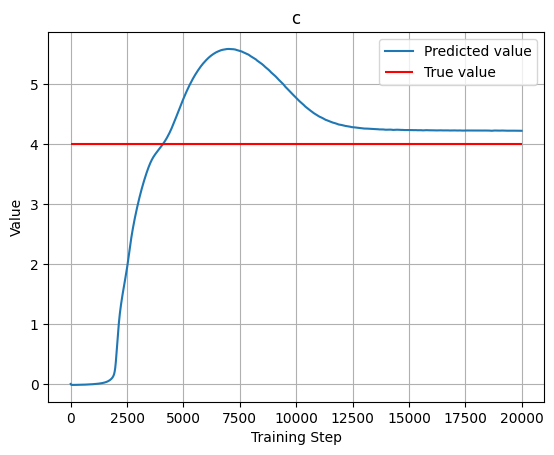

In [8]:
plt.plot(c_values, label="Predicted value")
plt.hlines(2 * d, 0, len(c_values), label="True value", colors="red")
plt.xlabel("Training Step")
plt.ylabel("Value")
plt.title("c")
plt.legend()
plt.grid(True)
plt.show()